# 16CygB

In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os, sys
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
scripts_path = "../../../scripts" #os.path.join(repo_root, 'scripts')
sys.path.append(scripts_path)

import prior_funcs, utils
from pitchfork_funcs import emulator
from pitchfork_funcs import nested_sampler



import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="1"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

2025-02-26 13:14:24.901938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 13:14:24.913347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 13:14:24.916770: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 13:14:25.466238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Import pitchfork

In [2]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork_path = "../../../pitchfork/"

pitchfork = emulator(pitchfork_name, file_path=pitchfork_path)


with open(pitchfork_path+ pitchfork_name+'.pkl', 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


## save observed/published parameters

In [3]:
#parameters for star, [value,unc], NaN for not found/published
# MLT from Farnir 2020: https://www.aanda.org/articles/aa/pdf/2020/12/aa38522-20.pdf
# T and R from White 2013: https://academic.oup.com/mnras/article/433/2/1262/1748898
# L from Metcalfe 2012: https://iopscience.iop.org/article/10.1088/2041-8205/748/1/L10/pdf
# M, Z, Y, Age, from Metcalfe 2015: https://iopscience.iop.org/article/10.1088/2041-8205/811/2/L37/pdf
# [Fe/H] from Ramirez 2009: https://www.aanda.org/articles/aa/pdf/2009/46/aa13038-09.pdf
# Freqs from Lund : https://iopscience.iop.org/article/10.3847/1538-4357/835/2/172/pdf

star_name = '16CygB'
star_KIC = '12069449'

star_dict={}

star_dict['initial_mass']=[1.04, 0.02]
star_dict['initial_Zinit']= [0.021, 0.002]
star_dict['initial_Yinit']= [0.25, 0.01]
star_dict['initial_MLT']= [1.99, 0.06]
star_dict['star_age']=[7.0, 0.3]

star_dict['calc_effective_T']=[5809, 39]
star_dict['radius']=[1.12, 0.02]
star_dict['luminosity']=[1.27, 0.04]
star_dict['star_feh']=[0.052,0.021]


############# Freqs from table
freqs = ascii.read(f"../../table6.dat", readme = f"../../ReadMe") 

freqs = freqs[freqs['KIC']==star_KIC]
freqs = freqs[freqs['l']==0]

i=0
for n in freqs['n']:
    freq_list = [freqs['Freq'][i], freqs['e_Freq'][i]]
    star_dict[f'nu_0_{n}'] = freq_list
    i+=1

##############

params = ascii.read(f"../../table1.dat", readme = f"../../ReadMe") 
params = params[params['KIC']==star_KIC]

star_dict['dnu'] = [params['Dnu'].value[0],0]
star_dict['nu_max'] = [float(params['numax'].value[0]),0]


with open(f'{star_name}.json', 'w') as fp:
    json.dump(star_dict, fp)

star_dict


{'initial_mass': [1.04, 0.02],
 'initial_Zinit': [0.021, 0.002],
 'initial_Yinit': [0.25, 0.01],
 'initial_MLT': [1.99, 0.06],
 'star_age': [7.0, 0.3],
 'calc_effective_T': [5809, 39],
 'radius': [1.12, 0.02],
 'luminosity': [1.27, 0.04],
 'star_feh': [0.052, 0.021],
 'nu_0_13': [1695.02292, 0.14096],
 'nu_0_14': [1812.44447, 0.1465],
 'nu_0_15': [1928.88625, 0.11],
 'nu_0_16': [2044.35684, 0.07089],
 'nu_0_17': [2159.50294, 0.0568],
 'nu_0_18': [2275.94878, 0.04924],
 'nu_0_19': [2392.64451, 0.0455],
 'nu_0_20': [2509.67826, 0.04333],
 'nu_0_21': [2626.45779, 0.05174],
 'nu_0_22': [2743.32186, 0.06584],
 'nu_0_23': [2860.68003, 0.09407],
 'nu_0_24': [2978.17998, 0.17118],
 'nu_0_25': [3097.16961, 0.41425],
 'nu_0_26': [3216.45122, 0.45259],
 'nu_0_27': [3336.00875, 1.03806],
 'dnu': [116.9, 0],
 'nu_max': [2561.0, 0]}

## define priors

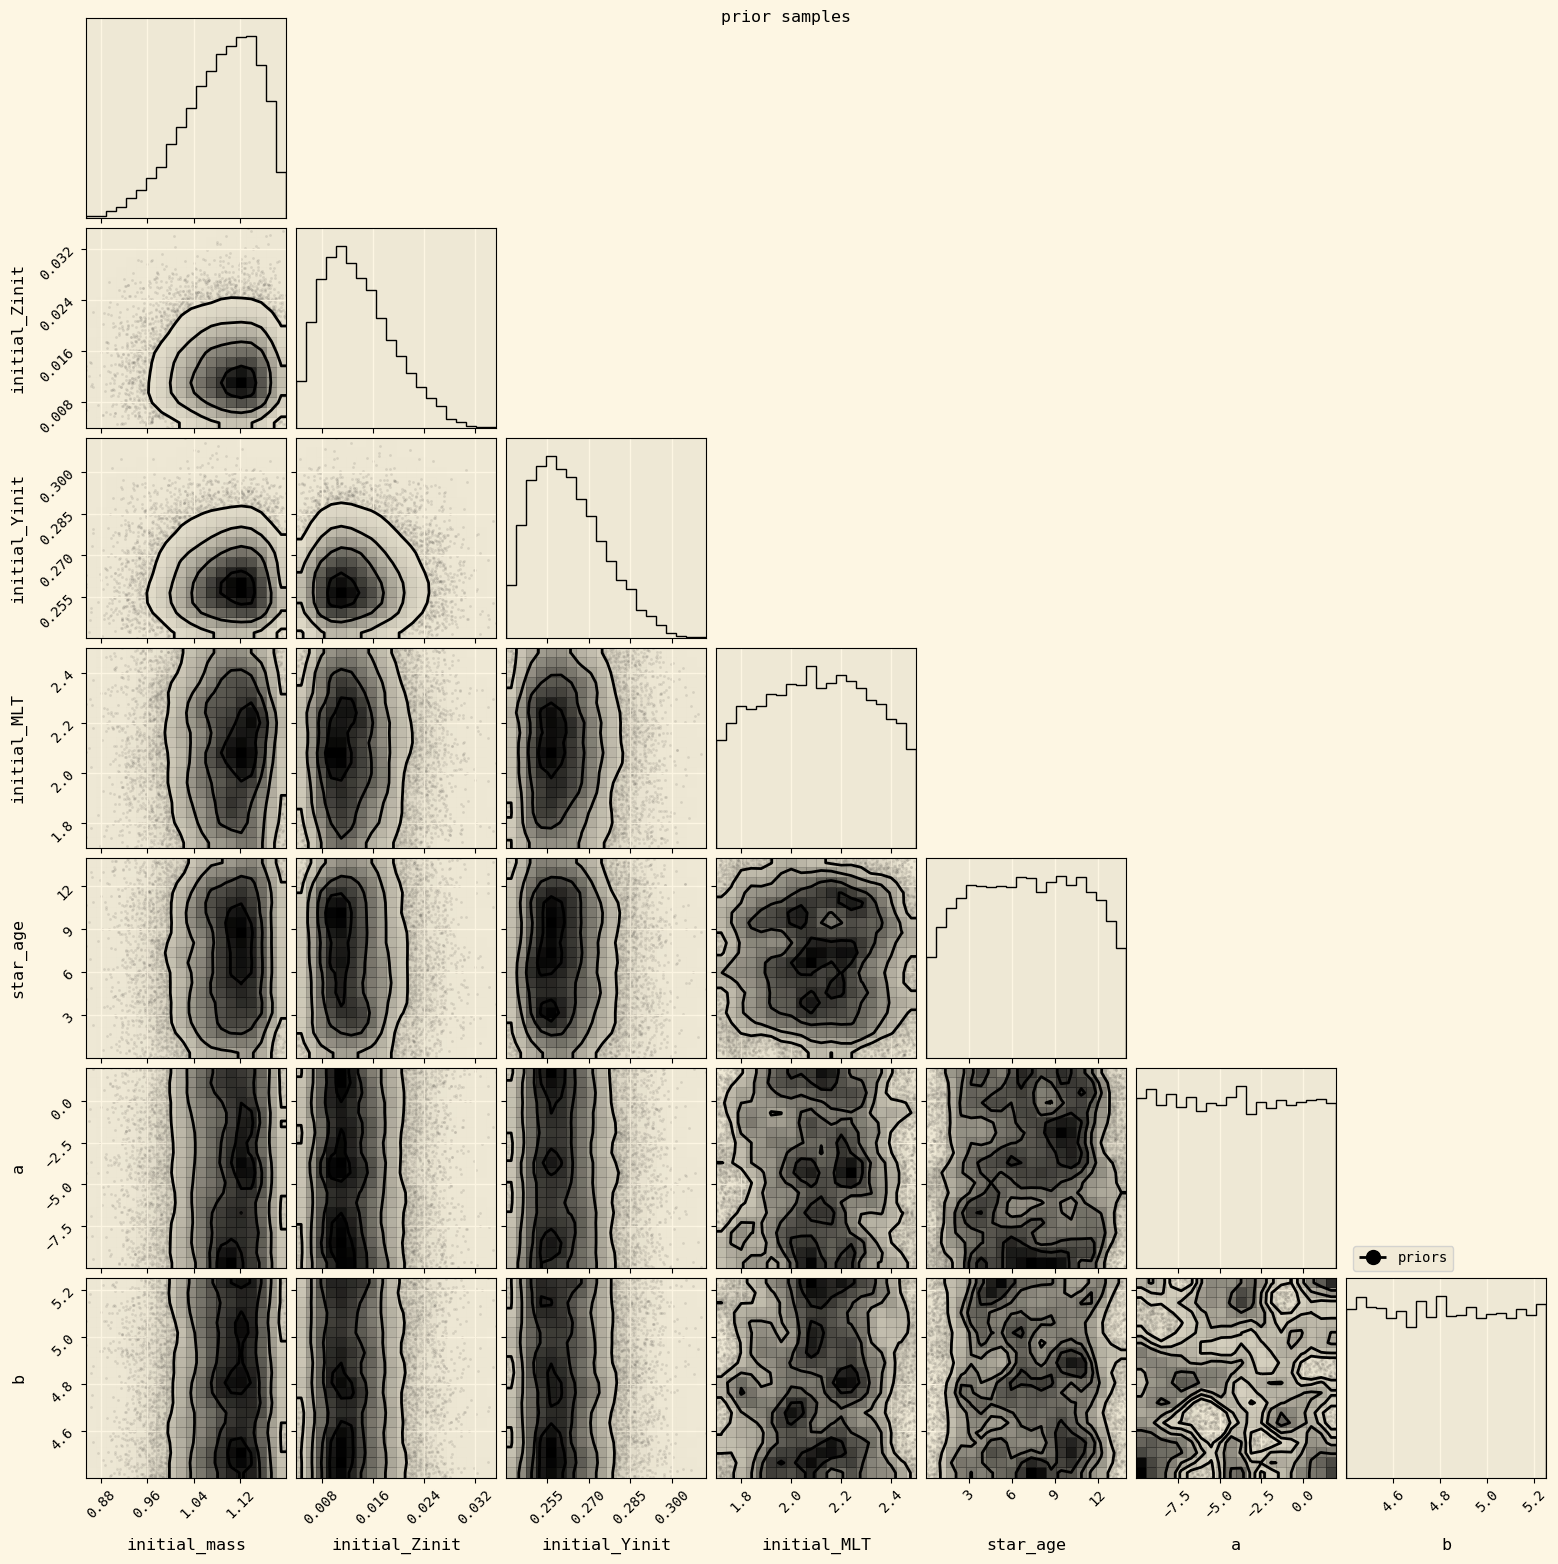

In [4]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

## pre-sampling step
define relevant covariance matrices for likelihood, inputs and outputs etc

In [5]:
star_json = f'{star_name}.json'

star_df = pd.read_json(star_json).dropna(axis=1)

star_vals_df = star_df.iloc[[0]]

star_uncs_df = star_df.iloc[[1]]

star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

nu_max = star_df["nu_max"].values[0]

### obs matrix
star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

sigma_obs = (star_obs_uncs_df.values[0]*star_obs_uncs_df.values[0])*(np.identity(len(star_obs_uncs_df.values[0])))

### nn matrix
with open(pitchfork_path+ "/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))

sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
sigma_nn_mask[:3] = True
sigma_nn_mask[n_min-3:n_max-2] = True

sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

### gp matrix
obs_freqs = star_vals_df[[f"nu_0_{i}" for i in range(n_min, n_max+1)]].iloc[0].values.flatten()

dnu = star_df['dnu'].values[0]

kernel = 4*kernels.ExpSquared(scale=5*dnu)

gp = GaussianProcess(kernel, obs_freqs, diag=1e-12)

gp_cov = tinygp.solvers.DirectSolver.init(kernel, obs_freqs, noise=tinygp.noise.Dense(value=np.zeros((len(obs_freqs),len(obs_freqs))))).covariance()

gp_cov_padded = np.pad(gp_cov, (3,0))

# add covariance matrices
sigma = sigma_nn_cropped + sigma_obs + gp_cov_padded

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

In [7]:
%%time

import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

    
ndraw_min=2**16
ndraw_max=2**19
min_num_live_points = 400

print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
sampler = nested_sampler(priors=priors, observed_vals=star_obs_vals_df.values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=min_num_live_points, cluster_num_live_points=.1*min_num_live_points, frac_remain=.01)#, max_ncalls=5e6)

with open('samples.pkl', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

sampler.cleanup()

del results

|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |
|---------------:|----------------:|----------------:|--------------:|-----------:|
|           1.04 |           0.021 |            0.25 |          1.99 |          7 |


/home/oxs235/miniconda3/envs/jaxtf/lib/python3.12/site-packages/ultranest/integrator.py:1896: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


CPU times: user 49min 8s, sys: 3min 16s, total: 52min 25sit/evals=7245/392039 eff=1.4220% N=400    
Wall time: 51min 55s


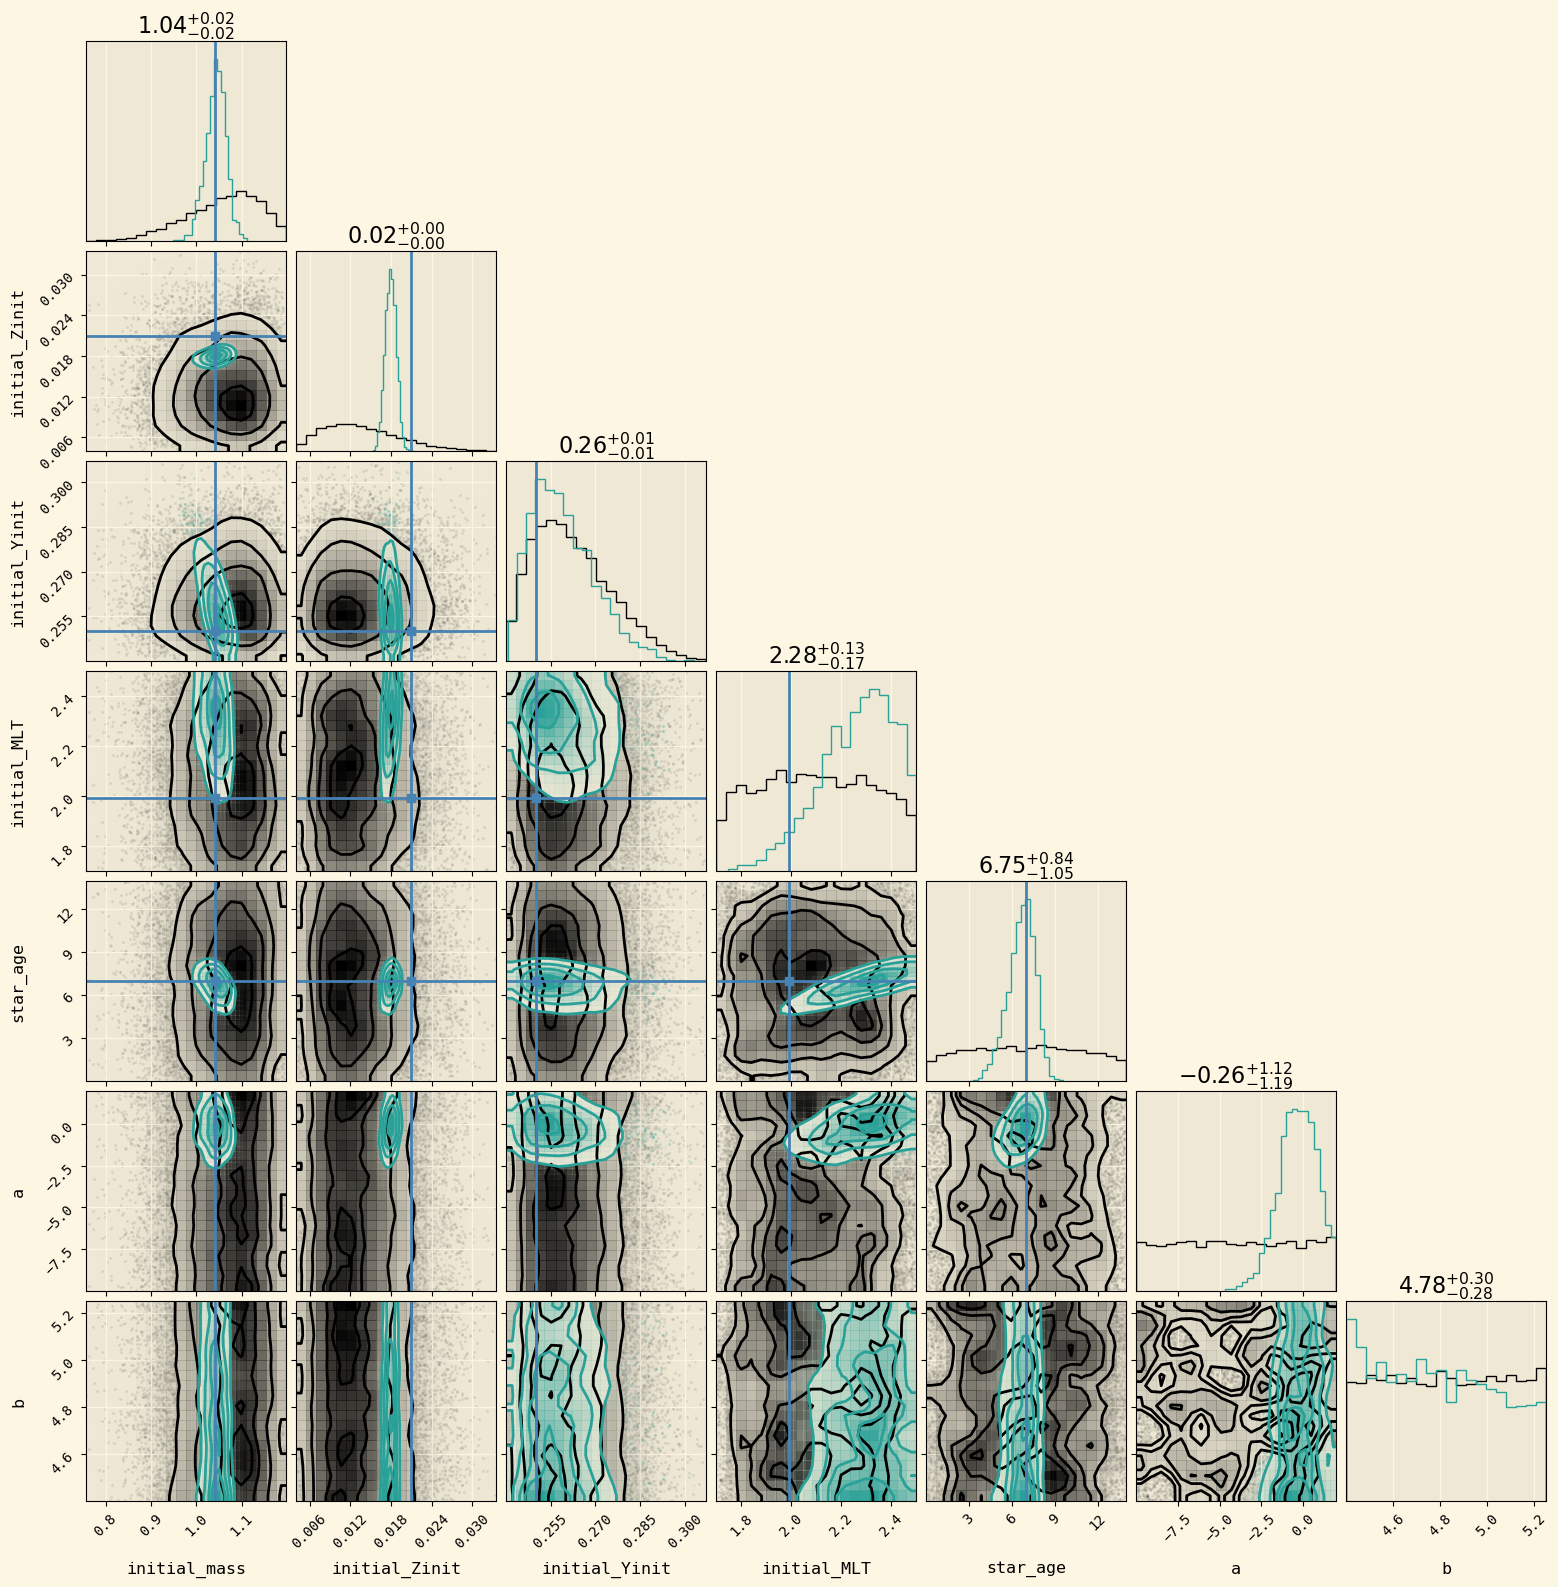

In [8]:
def inspect_star(path):

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.7, 1.2, a=5, b=2)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    

    star_json = f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)

    published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

    with open('samples.pkl', 'rb') as fp:
     samples = pickle.load(fp)

    
    corner.corner(samples['samples'], fig=figure, color=colors[1], truths = published_inps, hist_kwargs={'density':True}, smooth=True,show_titles=True);

    plt.show()

    
inspect_star(star_name)

0       1.121520
1       1.113360
2       1.101187
3       1.118463
4       1.131809
          ...   
4774    1.133114
4775    1.127442
4776    1.135925
4777    1.128422
4778    1.126072
Name: radius, Length: 4779, dtype: float64


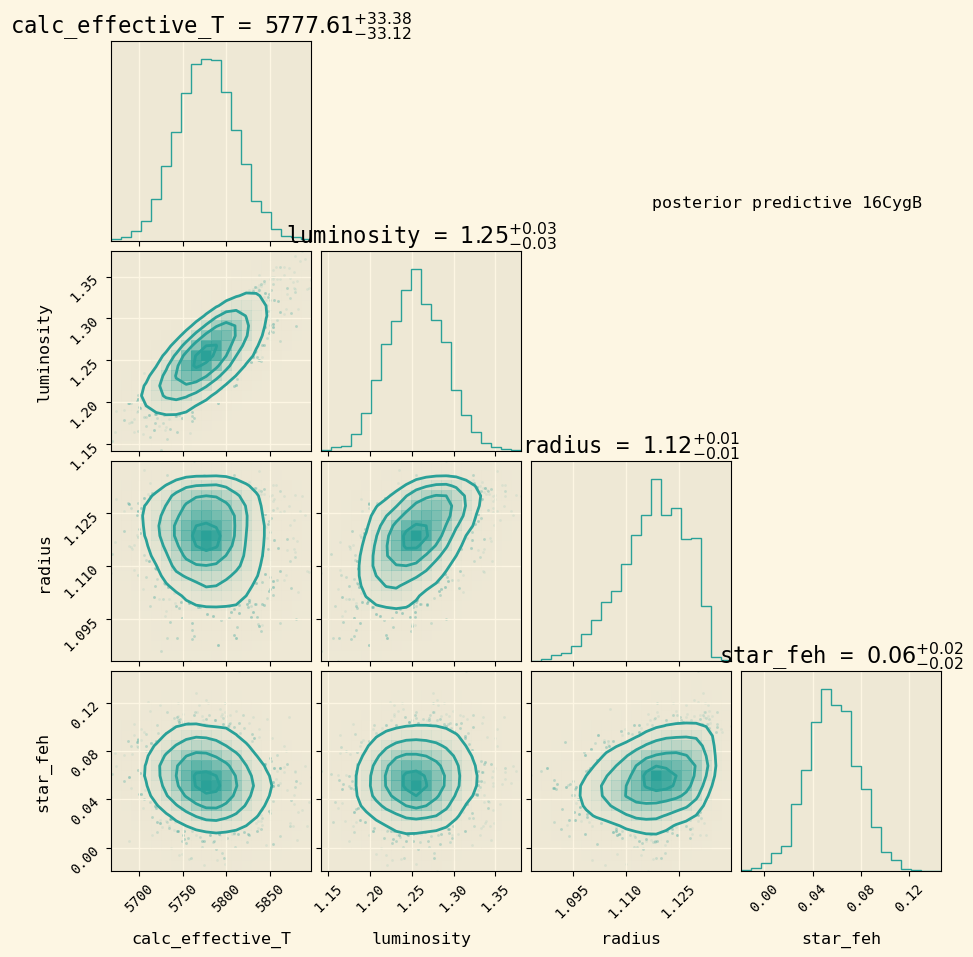

nu_0_13    1693.905310
nu_0_14    1811.203027
nu_0_15    1927.911526
nu_0_16    2043.969952
nu_0_17    2159.984944
nu_0_18    2276.604671
nu_0_19    2393.937187
nu_0_20    2511.673239
nu_0_21    2629.585368
nu_0_22    2747.633304
nu_0_23    2865.909437
nu_0_24    2984.481478
nu_0_25    3103.323127
nu_0_26    3222.427192
dtype: float64
[1695.02292]
[1812.44447]
[1928.88625]
[2044.35684]
[2159.50294]
[2275.94878]
[2392.64451]
[2509.67826]
[2626.45779]
[2743.32186]
[2860.68003]
[2978.17998]
[3097.16961]
[3216.45122]


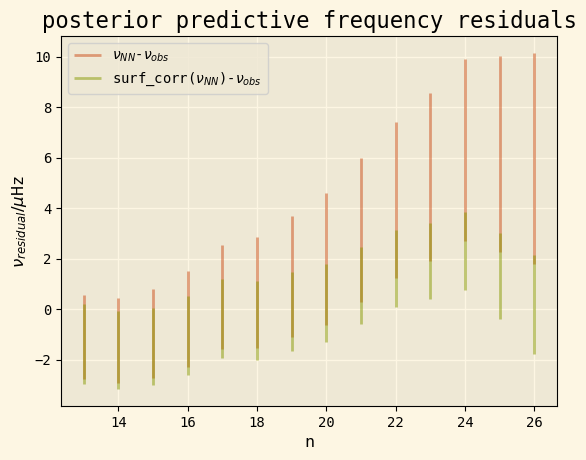

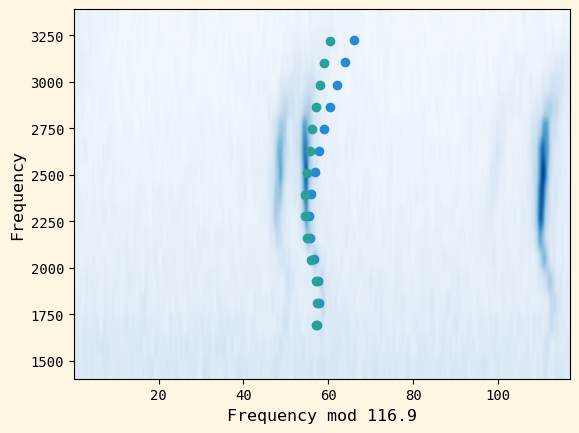

In [17]:
def posterior_pred(pitchfork, star_name):

    path = f'stars/{star_name}/'

    with open(path+f'/samples.pkl', 'rb') as fp:
        samples = pickle.load(fp)

    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)
    
    star_vals_df = star_df.iloc[[0]]
    
    star_uncs_df = star_df.iloc[[1]]
    
    star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    nu_max = star_df["nu_max"].values[0]
    
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

    samples_df = pd.DataFrame(samples['samples'], columns=labels)

    preds_array = pitchfork.predict(samples_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']])
    output_labels = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(6, 41)
    ]
    
    
    preds_df = pd.DataFrame(preds_array, columns=output_labels)

    preds_df['radius'] = (np.sqrt((preds_df['luminosity']*astropy.constants.L_sun)/(4*np.pi*constants.sigma*(preds_df['calc_effective_T']**4))))/astropy.constants.R_sun

    print(preds_df['radius'])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    figure = corner.corner(preds_df[["calc_effective_T", "luminosity", "radius", "star_feh"]], labels = ["calc_effective_T", "luminosity", "radius", "star_feh"], color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle(f'posterior predictive {star_name}', x=0.8, y=0.8)
    plt.show()

    ### freqs posterior preds

    n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
    n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))
    pred_freqs = preds_df[[f"nu_0_{i}" for i in range(n_min, n_max)]]
    print(np.mean(pred_freqs, axis=0))
    

    ## corrected freq posterior pred
    def surf_corr(freqs, nu_max, a, b):
        return freqs + a * ((freqs / nu_max) ** b)

    a_samples = samples_df['a'].values
    b_samples = samples_df['b'].values
    
    for n in range(n_min, n_max):
        n_samples = pred_freqs[f"nu_0_{n}"].values
        observed_freqs = star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1)[f"nu_0_{n}"].values
        print(observed_freqs)

        n_samples_residual = n_samples - np.full(len(n_samples),observed_freqs)

        ### keep for lines
        n_samples_residual_mu = n_samples_residual.mean()
        n_samples_residual_std = n_samples_residual.std()

        plot_upper = n_samples_residual_mu + n_samples_residual_std
        plot_lower = n_samples_residual_mu - n_samples_residual_std
        if n == n_min:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[4], label=r'$\nu_{NN}$-$\nu_{obs}$',alpha=.5)
        else:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[4],alpha=.5)


        
        n_samples_corr = surf_corr(n_samples, nu_max, a_samples, b_samples)
        
        n_samples_residual = n_samples_corr - np.full(len(n_samples_corr),observed_freqs)

        ### keep for lines
        n_samples_residual_mu = n_samples_residual.mean()
        n_samples_residual_std = n_samples_residual.std()

        plot_upper = n_samples_residual_mu + n_samples_residual_std
        plot_lower = n_samples_residual_mu - n_samples_residual_std

        if n == n_min:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[2], label=r'surf_corr($\nu_{NN}$)-$\nu_{obs}$',alpha=.5)
        else:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[2],alpha=.5)
        ###

        ### keep for points
        #plt.scatter(np.full(len(n_samples_residual), n), n_samples_residual,c=colors[2], alpha=0.002)
    
        ###

    plt.legend()
    plt.xlabel('n')
    plt.ylabel(r'$\nu_{residual}/\mu$Hz')
    plt.title('posterior predictive frequency residuals')
    plt.show()

    from echelle import plot_echelle

    spectrum = np.loadtxt(f'stars/{star_name}/power.pow')
    freq = spectrum[:,0]
    power = spectrum[:,1]
    
    ax = plot_echelle(freq,power,dnu, scale = 'sqrt', fmin=1500, fmax=3500, interpolation='bicubic', smooth=True)

    mean_preds = np.mean(pred_freqs, axis=0)
    ax.scatter(mean_preds%dnu, mean_preds)

    corrected = surf_corr(mean_preds, nu_max, np.mean(a_samples), np.mean(b_samples))

    ax.scatter(corrected%dnu, corrected)
    
    plt.grid(visible=None)

posterior_pred(pitchfork, star_name)

0       1.121520
1       1.113360
2       1.101187
3       1.118463
4       1.131809
          ...   
4774    1.133114
4775    1.127442
4776    1.135925
4777    1.128422
4778    1.126072
Name: radius, Length: 4779, dtype: float64


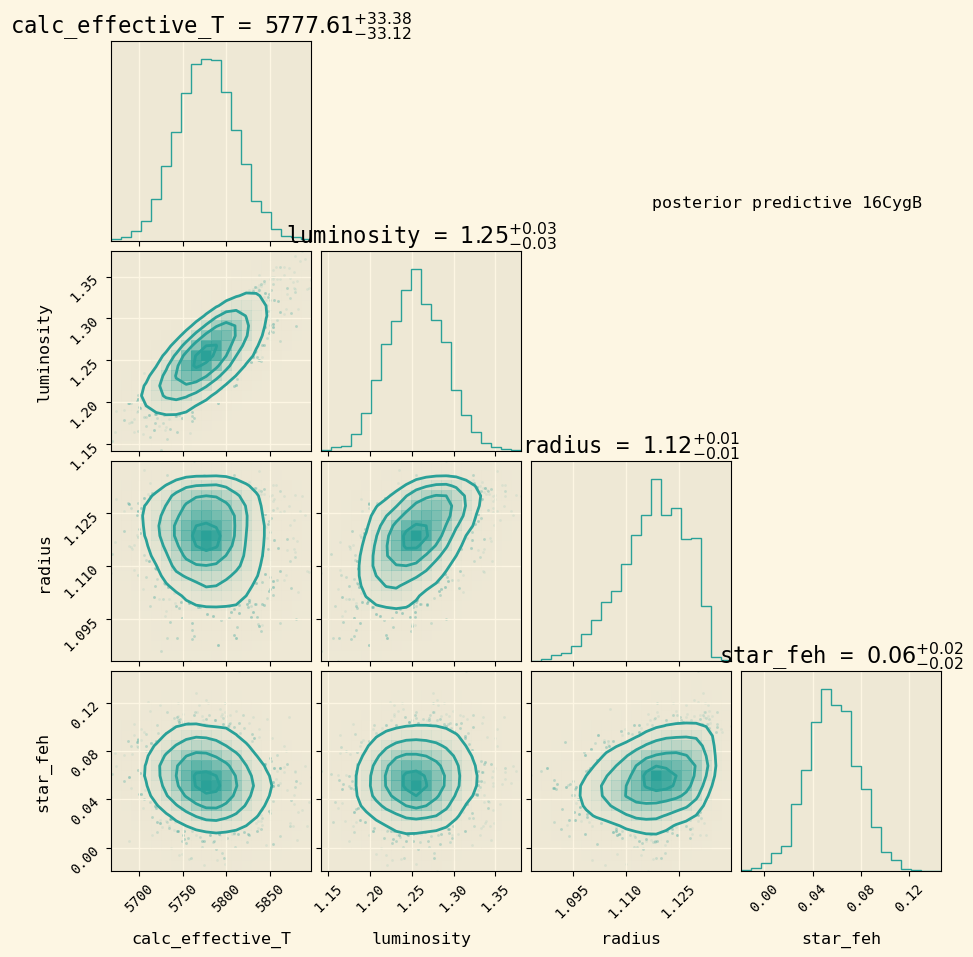

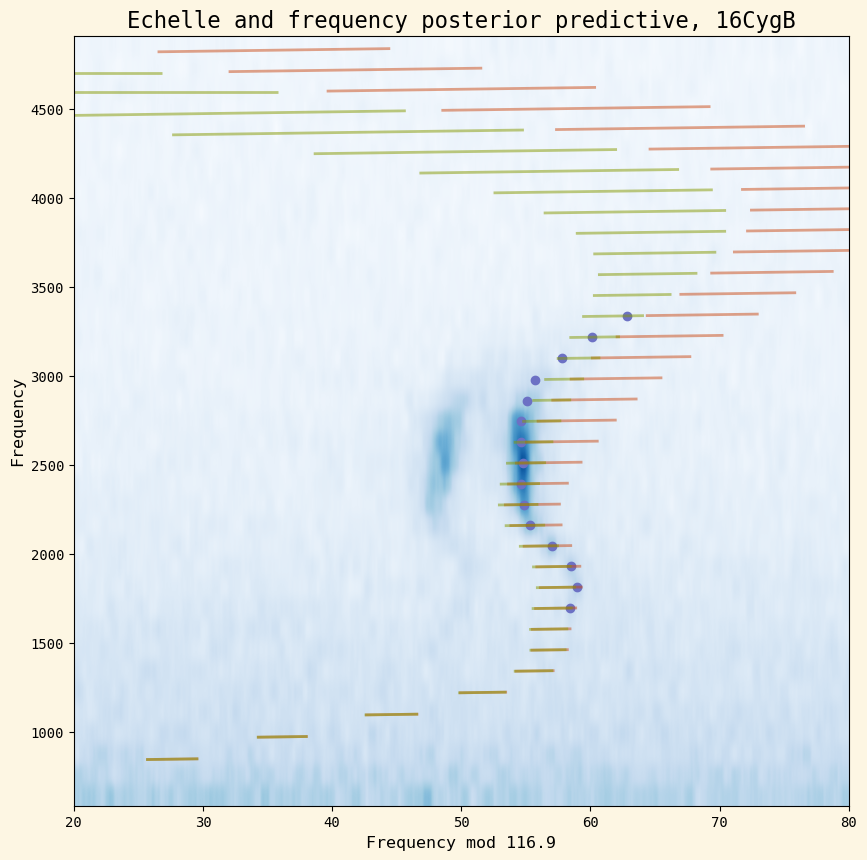

In [18]:
def posterior_pred(pitchfork, star_name):

    path = f'stars/{star_name}/'

    with open(path+f'/samples.pkl', 'rb') as fp:
        samples = pickle.load(fp)

    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)
    
    star_vals_df = star_df.iloc[[0]]
    
    star_uncs_df = star_df.iloc[[1]]
    
    star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    nu_max = star_df["nu_max"].values[0]
    
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

    samples_df = pd.DataFrame(samples['samples'], columns=labels)

    preds_array = pitchfork.predict(samples_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']])
    output_labels = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(6, 41)
    ]
    
    
    preds_df = pd.DataFrame(preds_array, columns=output_labels)

    preds_df['radius'] = (np.sqrt((preds_df['luminosity']*astropy.constants.L_sun)/(4*np.pi*constants.sigma*(preds_df['calc_effective_T']**4))))/astropy.constants.R_sun

    print(preds_df['radius'])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    figure = corner.corner(preds_df[["calc_effective_T", "luminosity", "radius", "star_feh"]], labels = ["calc_effective_T", "luminosity", "radius", "star_feh"], color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle(f'posterior predictive {star_name}', x=0.8, y=0.8)
    plt.show()

    ### freqs posterior preds

    n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
    n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))
    #print(len(pred_freqs))
    

    ## corrected freq posterior pred
    def surf_corr(freqs, nu_max, a, b):
        return freqs + a * ((freqs / nu_max) ** b)

    a_samples = samples_df['a'].values
    b_samples = samples_df['b'].values
    
    from echelle import plot_echelle

    spectrum = np.loadtxt(f'stars/{star_name}/power.pow')
    freq = spectrum[:,0]
    power = spectrum[:,1]
    
    fig, ax = plt.subplots(figsize=[10, 10])
    plot_echelle(freq,power,dnu, scale = 'sqrt', fmin=600, fmax=5000, interpolation='bicubic', smooth=True, ax=ax)

    echelle_c = colors[4]
    echelle_a = 0.5
    
    pred_freqs_array = preds_df[[f"nu_0_{i}" for i in range(6, 41)]]
    for n in range(6,41):
        pred_freqs = pred_freqs_array[f'nu_0_{n}'].values
        pred_freqs_mean = np.mean(pred_freqs)
        pred_freqs_std = np.std(pred_freqs)
        
        plot_lower_y = pred_freqs_mean - pred_freqs_std
        plot_lower_x = plot_lower_y%dnu

        plot_upper_y = pred_freqs_mean + pred_freqs_std
        plot_upper_x = plot_upper_y%dnu

        if plot_lower_x < plot_upper_x:
            ax.plot([plot_lower_x, plot_upper_x], [plot_lower_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
        else:
            ax.plot([0, plot_upper_x], [plot_upper_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
            ax.plot([plot_lower_x, dnu], [plot_lower_y, plot_lower_y], color=echelle_c, alpha=echelle_a)

    
    corrected_array = surf_corr(pred_freqs_array, nu_max, np.tile(a_samples,(35,1)).T,np.tile(b_samples,(35,1)).T)
    echelle_c = colors[2]
    echelle_a = 0.5
    for n in range(6,41):
        corrected_freqs = corrected_array[f'nu_0_{n}'].values
        corrected_freqs_mean = np.mean(corrected_freqs)
        corrected_freqs_std = np.std(corrected_freqs)
        
        plot_lower_y = corrected_freqs_mean - corrected_freqs_std
        plot_lower_x = plot_lower_y%dnu

        plot_upper_y = corrected_freqs_mean + corrected_freqs_std
        plot_upper_x = plot_upper_y%dnu

        if plot_lower_x < plot_upper_x:
            ax.plot([plot_lower_x, plot_upper_x], [plot_lower_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
        else:
            ax.plot([0, plot_upper_x], [plot_upper_y, plot_upper_y], color=echelle_c, alpha=echelle_a)
            ax.plot([plot_lower_x, dnu], [plot_lower_y, plot_lower_y], color=echelle_c, alpha=echelle_a)

    obs_freqs = star_vals_df[[f'nu_0_{n}' for n in range(n_min, n_max+1)]].values
    ax.scatter(obs_freqs%dnu, obs_freqs, color= colors[7])

    plt.title(f'Echelle and frequency posterior predictive, {star_name}')
    plt.grid(visible=None)
    plt.xlim(xmin=20, xmax=80)

posterior_pred(pitchfork, star_name)

0       1.121520
1       1.113360
2       1.101187
3       1.118463
4       1.131809
          ...   
4774    1.133114
4775    1.127442
4776    1.135925
4777    1.128422
4778    1.126072
Name: radius, Length: 4779, dtype: float64


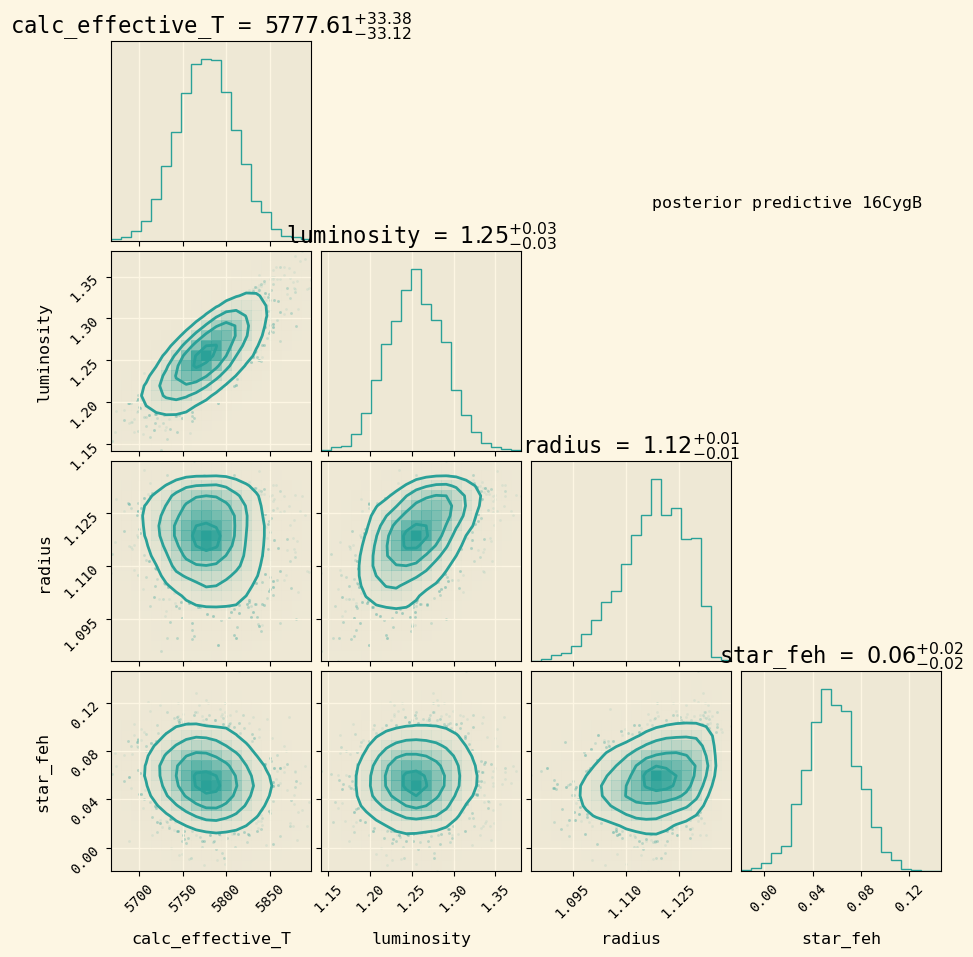

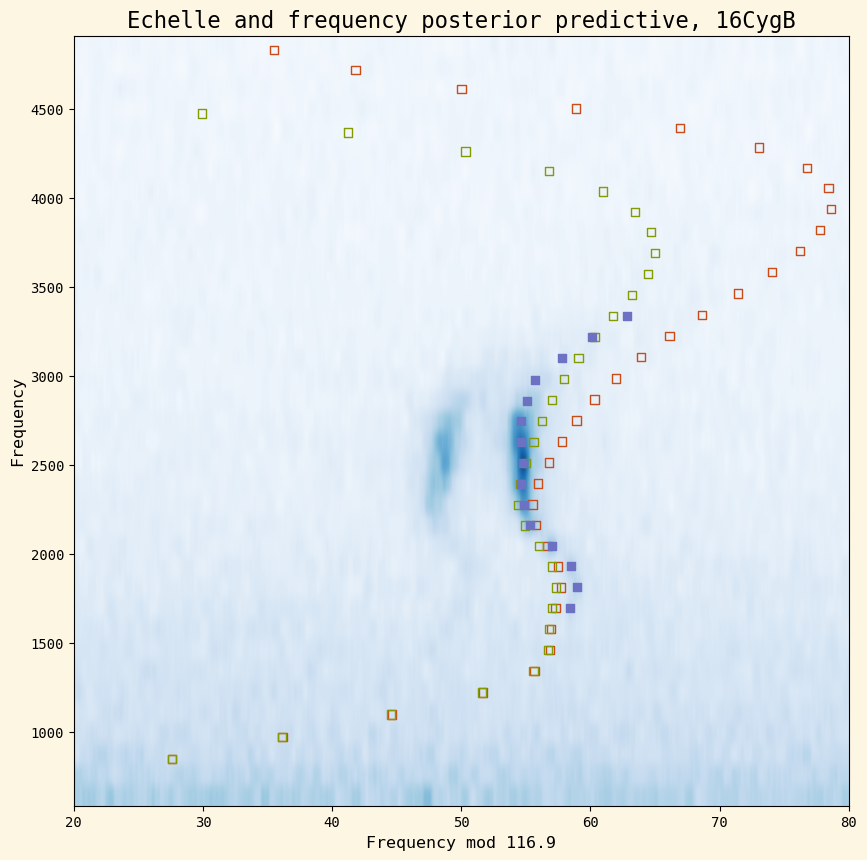

In [19]:
def posterior_pred(pitchfork, star_name):

    path = f'stars/{star_name}/'

    with open(path+f'/samples.pkl', 'rb') as fp:
        samples = pickle.load(fp)

    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)
    
    star_vals_df = star_df.iloc[[0]]
    
    star_uncs_df = star_df.iloc[[1]]
    
    star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    nu_max = star_df["nu_max"].values[0]
    
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

    samples_df = pd.DataFrame(samples['samples'], columns=labels)

    preds_array = pitchfork.predict(samples_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']])
    output_labels = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(6, 41)
    ]
    
    
    preds_df = pd.DataFrame(preds_array, columns=output_labels)

    preds_df['radius'] = (np.sqrt((preds_df['luminosity']*astropy.constants.L_sun)/(4*np.pi*constants.sigma*(preds_df['calc_effective_T']**4))))/astropy.constants.R_sun

    print(preds_df['radius'])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    figure = corner.corner(preds_df[["calc_effective_T", "luminosity", "radius", "star_feh"]], labels = ["calc_effective_T", "luminosity", "radius", "star_feh"], color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle(f'posterior predictive {star_name}', x=0.8, y=0.8)
    plt.show()

    ### freqs posterior preds

    n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
    n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))
    #print(len(pred_freqs))
    

    ## corrected freq posterior pred
    def surf_corr(freqs, nu_max, a, b):
        return freqs + a * ((freqs / nu_max) ** b)

    a_samples = samples_df['a'].values
    b_samples = samples_df['b'].values
    
    from echelle import plot_echelle

    spectrum = np.loadtxt(f'stars/{star_name}/power.pow')
    freq = spectrum[:,0]
    power = spectrum[:,1]
    
    fig, ax = plt.subplots(figsize=[10, 10])
    plot_echelle(freq,power,dnu, scale = 'sqrt', fmin=600, fmax=5000, interpolation='bicubic', smooth=True, ax=ax, cmap="Blues")

    echelle_c = colors[4]
    echelle_a = 0.3
    
    pred_freqs_array = preds_df[[f"nu_0_{i}" for i in range(6, 41)]]
    for n in range(6,41):
        pred_freqs = pred_freqs_array[f'nu_0_{n}'].values
        pred_freqs_mean = np.mean(pred_freqs)
        ax.scatter(pred_freqs_mean%dnu, pred_freqs_mean, color=echelle_c, marker = 's', facecolors='none')
    
    corrected_array = surf_corr(pred_freqs_array, nu_max, np.tile(a_samples,(35,1)).T,np.tile(b_samples,(35,1)).T)
    echelle_c = colors[2]
    echelle_a = 0.3
    for n in range(6,41):
        corrected_freqs = corrected_array[f'nu_0_{n}'].values
        corrected_freqs_mean = np.mean(corrected_freqs)
        ax.scatter(corrected_freqs_mean%dnu, corrected_freqs_mean, color=echelle_c, marker = 's', facecolors='none')

    obs_freqs = star_vals_df[[f'nu_0_{n}' for n in range(n_min, n_max+1)]].values
    ax.scatter(obs_freqs%dnu, obs_freqs, color= colors[7], marker='s')

    plt.title(f'Echelle and frequency posterior predictive, {star_name}')
    plt.grid(visible=None)
    plt.xlim(xmin=20, xmax=80)

posterior_pred(pitchfork, star_name)